<h1><center> Reflectometry simulations performance - BornAgain vs Refnx </center></h1>


In this notebook, performance tests for BornAgain reflectometry simulations are carried out and the calculation's bottleneck is found. To have some ground for comparison, the same performance tests are made for Refnx:

 - Time scaling with the number of layers
 - Time taken to run a simple simulation
 - Time scaling with the simulation resolution
 

In [1]:
%reset -f
# Generic modules:
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime as dtime
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import os.path
import time
%matplotlib inline

# Bornagain modules:
import bornagain as ba
from bornagain import deg, angstrom

# Refnx modules:
import refnx, scipy
from refnx.reflect import SLD, ReflectModel, Slab, Structure, LipidLeaflet

# Modules for profiling:
import cProfile, pstats, io

# Global vars:
WAVELENGTH = 1.00
THETA_VALUES = np.linspace(0.0,10,1025)
Q_VALUES = 4.0*np.pi*np.sin(THETA_VALUES*np.pi/180.0)/WAVELENGTH
N_LAYERS = 10

def plot_timings_comparison(ba_t, rfnx_t, x_label):
    FigSize = 20
    FontSize = 20
    BorderWidth = 3
    plt.rcParams.update({'font.size': FontSize})
    plt.rcParams.update({'axes.linewidth': BorderWidth})    
    plt.figure(figsize=(7,7))
    plt.plot(ba_t[:,0], ba_t[:,1], 'o-',label = "BornAgain")
    plt.plot(rfnx_t[:,0], rfnx_t[:,1], 'o-',label = "Refnx")
    plt.legend()
    plt.grid()
    plt.ylabel("$t \, [s]$")
    plt.xlabel(x_label)
    
def profile(fnc):
    """
    A decorator that uses cProfile to profile a function
    """
    
    def inner(*args, **kwargs):
        pr = cProfile.Profile()
        pr.enable()
        retval = fnc(*args, **kwargs)
        pr.disable()
        s = io.StringIO()
        sortby = 'cumulative'
        ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
        ps.print_stats()
        print(s.getvalue())
        return retval

    return inner

# Benchmark model: Ti-Ni stacked layers

The Ti-Ni multilayer is a very simple model, reproduced with a high level of agreement between BornAgain and Refnx.

## Ti-Ni model in Bornagain

In [2]:
def ba_reflectivity(multilayer,theta_vals):
    wavelength = 1.0 * ba.angstrom
    simulation = ba.SpecularSimulation()
    simulation.setBeamParameters(wavelength, theta_vals * deg)
    simulation.setSample(multilayer)
    simulation.runSimulation()
    results = simulation.result()
    simulation_data = results.data()
    return simulation_data.getArray()

def run_ba_model(num_bilayers,theta_vals):
    # creating materials
    m_ambient = ba.MaterialBySLD("Ambient", 0.0, 0.0)
    m_ti = ba.MaterialBySLD("Ti", -1.9493e-06, 0.0)
    m_ni = ba.MaterialBySLD("Ni", 9.4245e-06, 0.0)
    m_substrate = ba.MaterialBySLD("SiSubstrate", 2.0704e-06, 0.0)
    
    # creating layers
    ambient_layer = ba.Layer(m_ambient)
    ti_layer = ba.Layer(m_ti, 30 * angstrom)
    ni_layer = ba.Layer(m_ni, 70 * angstrom)
    substrate_layer = ba.Layer(m_substrate)
    
    # creating the multilayer
    ti_ni_multilayer = ba.MultiLayer()
    
    ti_ni_multilayer.addLayer(ambient_layer)
    for i in range(num_bilayers):
        ti_ni_multilayer.addLayer(ti_layer)
        ti_ni_multilayer.addLayer(ni_layer)
    ti_ni_multilayer.addLayer(substrate_layer)
    
    reflectivity_values = ba_reflectivity(ti_ni_multilayer,theta_vals)
    
    return reflectivity_values

@profile
def profile_ba_model(num_bilayers,theta_vals):
    return run_ba_model(num_bilayers,theta_vals)

## Ti-Ni model in Refnx

In [3]:
def refnx_reflectivity(structure,qvals):
    return ReflectModel(structure, scale=1.0, bkg=0.0, dq=0.0).model(qvals)

def run_refnx_model(num_bilayers,qvals):
    # set up the SLD objects for each layer
    sld_air = SLD(0.0 + 0.0j, name='air')
    sld_Ti = SLD(-1.9493 + 0.0j, name='Ti')
    sld_Ni = SLD(9.4245 + 0.0j, name='Ni')
    sld_Si = SLD(2.0704 +  0.0j, name='Si')
    
    # set up the Slab objects for each layer
    slab_air = Slab(0.0, sld_air, 0.0, name='air_slab')
    slab_Ti =  Slab(30.0, sld_Ti, 0.0, name ='Ti_slab')
    slab_Ni =  Slab(70.0, sld_Ni, 0.0, name ='Ni_slab')
    slab_Si =  Slab(0.0, sld_Si, 0.0, name ='Si_slab')

    # set up the Structure object from the Slabs
    structure = Structure()
    
    structure.append(slab_air)
    for i in range(num_bilayers):
        structure.append(slab_Ti)
        structure.append(slab_Ni)
    structure.append(slab_Si)
    
    reflectivity_values = refnx_reflectivity(structure,qvals)
    
    return reflectivity_values
    
@profile
def profile_refnx_model(num_bilayers,qvals):
    return run_refnx_model(num_bilayers,qvals)

# 1. Time scaling with the number of layers

In [4]:
ba_t = []
rfnx_t = []
for n_bilayers in [100,200,300,400,500,600,700,800,900,1000]:
    ba_t0 = time.time()
    run_ba_model(n_bilayers,THETA_VALUES)
    ba_tf = time.time()
    ba_t.append([n_bilayers, ba_tf-ba_t0])
    
    rfnx_t0 = time.time()
    run_refnx_model(n_bilayers,Q_VALUES)
    rfnx_tf = time.time()
    rfnx_t.append([n_bilayers, rfnx_tf-rfnx_t0])    
    
ba_t = np.asarray(ba_t)
rfnx_t = np.asarray(rfnx_t)

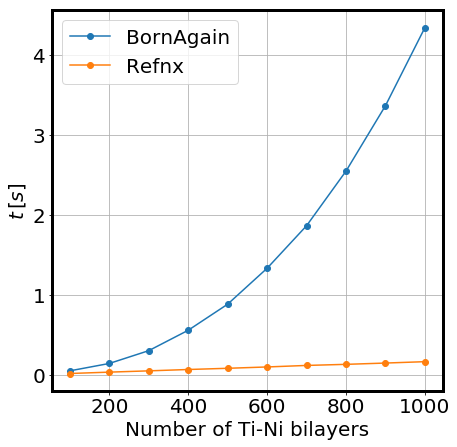

In [5]:
plot_timings_comparison(ba_t,rfnx_t,"Number of Ti-Ni bilayers")

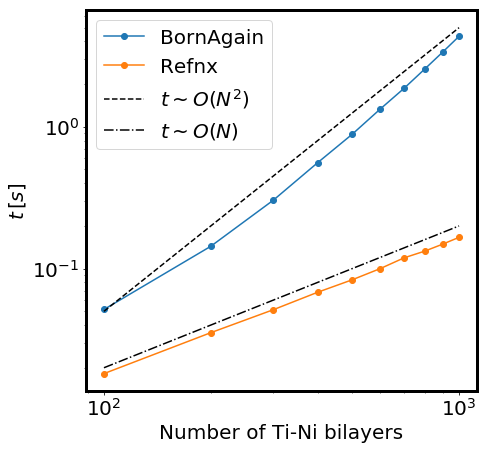

In [6]:
plt.figure(figsize=(7,7))
plt.loglog(ba_t[:,0],ba_t[:,1],'o-',label="BornAgain")
plt.loglog(rfnx_t[:,0],rfnx_t[:,1],'o-',label="Refnx")
plt.loglog(ba_t[:,0], 5e-6*ba_t[:,0]**2,'k--',label="$t \sim O(N^2)$")
plt.loglog(rfnx_t[:,0], 2e-4*rfnx_t[:,0],'k-.',label="$t \sim O(N)$")
plt.xlabel("Number of Ti-Ni bilayers")
plt.ylabel("$t \, [s]$")
plt.legend()

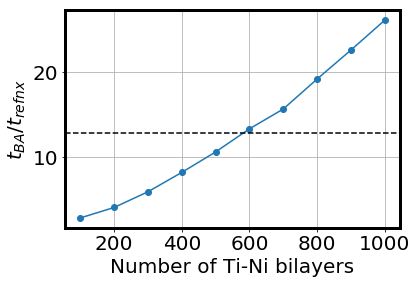

In [7]:
plt.plot(ba_t[:,0],ba_t[:,1]/rfnx_t[:,1],'o-')
plt.xlabel("Number of Ti-Ni bilayers")
plt.ylabel("$t_{BA} / t_{refnx}$")
plt.axhline(np.mean(ba_t[:,1]/rfnx_t[:,1]),ls='--',c='k')
plt.grid()

## BornAgain is performing very bad. Where is the bottleneck?
Profile a simulation using 1000 pairs of Ti-Ni bilayers

In [8]:
ba_results = profile_ba_model(1000,THETA_VALUES)

         4106 function calls in 4.344 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.001    0.001    4.344    4.344 <ipython-input-2-4ec528587fcd>:37(profile_ba_model)
        1    0.001    0.001    4.343    4.343 <ipython-input-2-4ec528587fcd>:11(run_ba_model)
        1    0.000    0.000    4.284    4.284 <ipython-input-2-4ec528587fcd>:1(ba_reflectivity)
        1    0.000    0.000    4.230    4.230 /usr/lib/python3/dist-packages/bornagain/libBornAgainCore.py:16390(runSimulation)
        1    4.230    4.230    4.230    4.230 {built-in method _libBornAgainCore.Simulation_runSimulation}
     2002    0.002    0.000    0.058    0.000 /usr/lib/python3/dist-packages/bornagain/libBornAgainCore.py:24881(addLayer)
     2002    0.056    0.000    0.056    0.000 {built-in method _libBornAgainCore.MultiLayer_addLayer}
        1    0.000    0.000    0.045    0.045 /usr/lib/python3/dist-packages/bornagain/libBornAgainCo

In [9]:
refnx_results = profile_refnx_model(1000,Q_VALUES)

         41247 function calls (41245 primitive calls) in 0.180 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.180    0.180 <ipython-input-3-bf3142e44831>:30(profile_refnx_model)
        1    0.000    0.000    0.180    0.180 <ipython-input-3-bf3142e44831>:4(run_refnx_model)
        1    0.000    0.000    0.177    0.177 <ipython-input-3-bf3142e44831>:1(refnx_reflectivity)
        1    0.000    0.000    0.177    0.177 /usr/local/lib/python3.5/dist-packages/refnx/reflect/reflect_model.py:153(model)
        1    0.000    0.000    0.161    0.161 /usr/local/lib/python3.5/dist-packages/refnx/reflect/reflect_model.py:228(reflectivity)
        1    0.161    0.161    0.161    0.161 {built-in method refnx.reflect._creflect.abeles}
        1    0.004    0.004    0.016    0.016 /usr/local/lib/python3.5/dist-packages/refnx/reflect/structure.py:151(slabs)
     2002    0.003    0.000    0.010    0.000 /us

 - BornAgain's bottleneck is inside `{built-in method _libBornAgainCore.Simulation_runSimulation}`  
 - Refnx's bottleneck is inside `{built-in method refnx.reflect._creflect.abeles}`

### Sanity check: be sure that the results from borh codes are consistent:

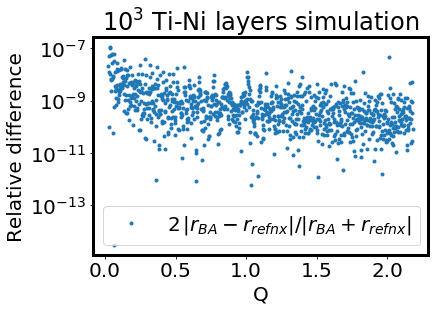

In [10]:
plt.title("$10^{3}$ Ti-Ni layers simulation")
plt.semilogy(Q_VALUES, 2.0 * np.abs(refnx_results-ba_results)/np.abs(refnx_results+ba_results), '.', 
            label = "$2 \, |r_{BA} - r_{refnx}|/|r_{BA} + r_{refnx}|$")
plt.xlabel("Q")
plt.ylabel("Relative difference")
plt.legend()
plt.show()

# 2. Time taken by a single simulation - 10 Ti-Ni bilayers

The time spent on a single simulation is measured by repeating the same simulation many times. Timings should scale linearly with the number of repetitions. It is found that each simulation takes around **5 ms in BornAgain**, two times as long as Refnx.

In [11]:
ba_t = []
rfnx_t = []
for n_repetitions in [500,600,700,800,900,1000,1250,1500,1750,2000]:
    ba_t0 = time.time()
    for i in range(n_repetitions):
        run_ba_model(N_LAYERS,THETA_VALUES)
    ba_tf = time.time()
    ba_t.append([n_repetitions, ba_tf-ba_t0])
    
    rfnx_t0 = time.time()
    for i in range(n_repetitions):
        run_refnx_model(N_LAYERS,Q_VALUES)
    rfnx_tf = time.time()
    rfnx_t.append([n_repetitions, rfnx_tf-rfnx_t0])    
    
ba_t = np.asarray(ba_t)
rfnx_t = np.asarray(rfnx_t)

[]

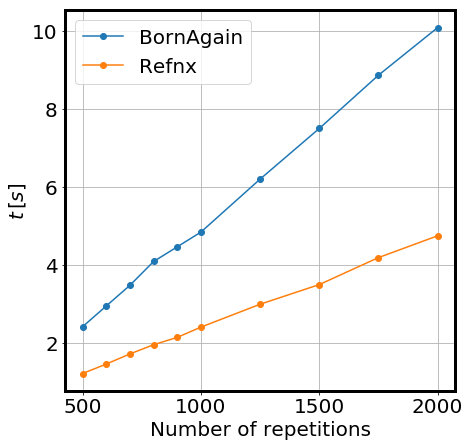

In [12]:
plot_timings_comparison(ba_t,rfnx_t,"Number of repetitions")
plt.plot()

Text(0.5, 1.0, '')

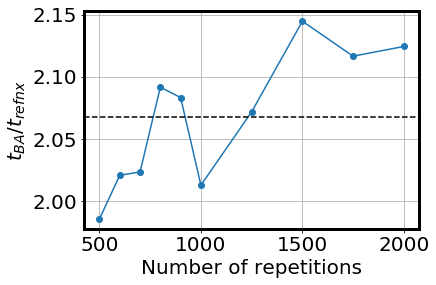

In [13]:
plt.plot(ba_t[:,0],ba_t[:,1]/rfnx_t[:,1],'o-')
plt.xlabel("Number of repetitions")
plt.ylabel("$t_{BA} / t_{refnx}$")
plt.axhline(np.mean(ba_t[:,1]/rfnx_t[:,1]),ls='--',c='k')
plt.grid()
plt.title("")

Text(0.5, 1.0, '')

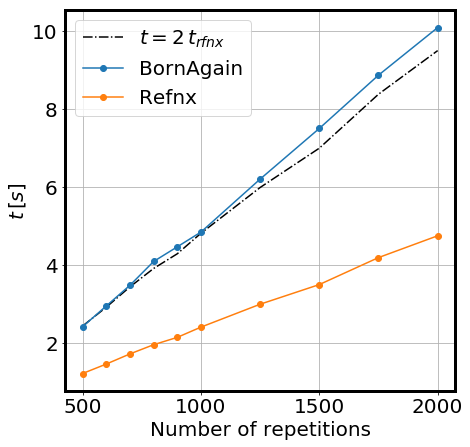

In [14]:
plt.figure(figsize=(7,7))
plt.plot(ba_t[:,0], 2*rfnx_t[:,1],'k-.',label="$t = 2 \, t_{rfnx}$")
plt.plot(ba_t[:,0],ba_t[:,1],'o-',label="BornAgain")
plt.plot(rfnx_t[:,0], rfnx_t[:,1],'o-',label="Refnx")
plt.xlabel("Number of repetitions")
plt.ylabel("$t \, [s]$")
plt.legend()
plt.grid()
plt.title("")

Text(0.5, 1.0, '')

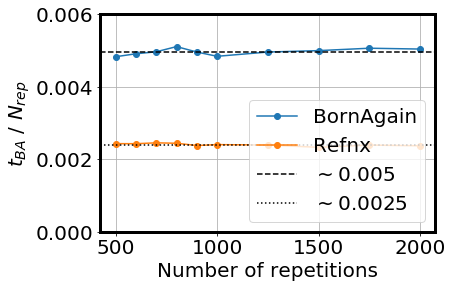

In [15]:
plt.plot(ba_t[:,0],ba_t[:,1]/ba_t[:,0],'o-', label = "BornAgain")
plt.plot(rfnx_t[:,0],rfnx_t[:,1]/rfnx_t[:,0],'o-', label= "Refnx")
plt.xlabel("Number of repetitions")
plt.ylabel("$t_{BA}$ / $N_{rep}$")
plt.axhline(np.mean(ba_t[:,1]/ba_t[:,0]),ls='--',c='k', label = "$\sim 0.005$")
plt.axhline(np.mean(rfnx_t[:,1]/rfnx_t[:,0]),ls=':',c='k', label = "$\sim 0.0025$")
plt.grid()
plt.ylim([0,6e-3])
plt.legend()
plt.title("")

# 3. Timing as function of resolution - Number of $\theta$ or $Q$ points

In [16]:
ba_t = []
rfnx_t = []
nPointsVals = [100,250,500,1000,2500,5000,10000,25000,50000,100000,250000,500000,10**6]
for n_points in nPointsVals:
    theta_vals = np.linspace(0.0,10,n_points)
    q_vals = 4.0*np.pi*np.sin(theta_vals*np.pi/180.0)
    
    ba_t0 = time.time()
    run_ba_model(N_LAYERS,theta_vals)
    ba_tf = time.time()
    
    rfnx_t0 = time.time()
    run_refnx_model(N_LAYERS,q_vals)
    rfnx_tf = time.time()
    
    ba_t.append([n_points, ba_tf-ba_t0])
    rfnx_t.append([n_points, rfnx_tf-rfnx_t0])    
    
ba_t = np.asarray(ba_t)
rfnx_t = np.asarray(rfnx_t)

Text(0.5, 1.0, '')

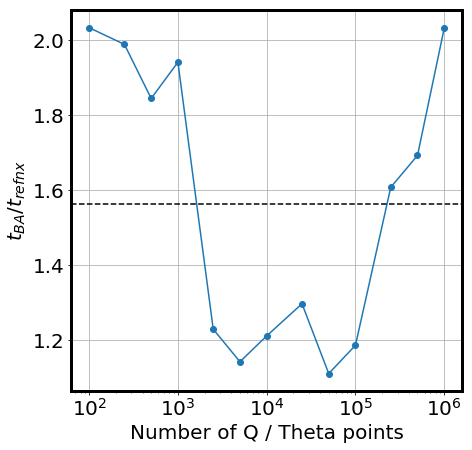

In [17]:
plt.figure(figsize=(7,7))
plt.semilogx(ba_t[:,0],ba_t[:,1]/rfnx_t[:,1],'o-')
plt.xlabel("Number of Q / Theta points")
plt.ylabel("$t_{BA} / t_{refnx}$")
plt.axhline(np.mean(ba_t[:,1]/rfnx_t[:,1]),ls='--',c='k')
plt.grid()
plt.title("")

Text(0.5, 1.0, '')

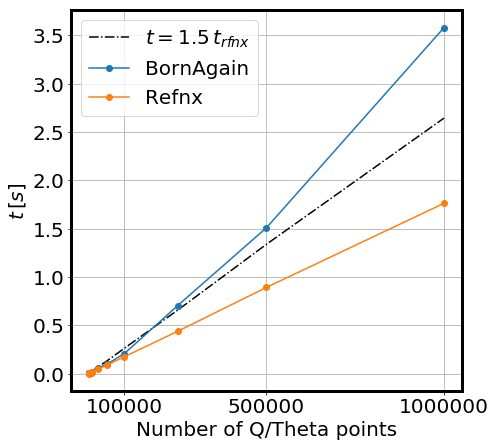

In [18]:
plt.figure(figsize=(7,7))
plt.plot(ba_t[:,0], 1.5*rfnx_t[:,1],'k-.',label="$t = 1.5 \, t_{rfnx}$")
plt.plot(ba_t[:,0],ba_t[:,1],'o-',label="BornAgain")
plt.plot(rfnx_t[:,0], rfnx_t[:,1],'o-',label="Refnx")
plt.xticks([10**5,5*10**5,10**6])
plt.xlabel("Number of Q/Theta points")
plt.ylabel("$t \, [s]$")
plt.legend()
plt.grid()
plt.title("")

# Conclusion

Bornagain is performing worse than Refnx in all three Reflectometry tests carried out in this notebook:
 - Time scaling with the number of layers
 - Time taken to run a simple simulation
 - Time scaling with the simulation resolution
 